# Data Preparation

In [65]:
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, auc
from sklearn.model_selection import train_test_split
import warnings

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline

In [66]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import plotly.graph_objects as go
from plotly.missing_ipywidgets import FigureWidget
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.figure_factory as ff
import plotly.offline as py
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot

import seaborn as sns
import missingno as msno


from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import KNNImputer
from sklearn.svm import SVR
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

from imblearn.over_sampling import SMOTE

import featuretools as ft

import tensorflow as tf

In [67]:
def read_and_set_df(filepath: str, train: bool) -> pd.DataFrame:

    # with open(filepath) as file:
    # file.readlines()

    # Datensatz einlesen
    df = pd.read_csv(filepath, sep='$',  # r'([$-,])+/g'
                     decimal=".", engine='python')  # , na_values=[np.nan, pd.NA], keep_default_na=True)

    # Spaltennamen alle kleingeschrieben
    df.columns = df.columns.str.lower()

    # Die Spaltennamen waren verschoben - In diesem Schritt werden sie richtig zugeordnet
    df.rename(columns={
        'unnamed: 0': 'id',
        'id': 'gender',
        'gender': 'age',
        'age': 'driving_license',
        'driving_license': 'region_code',
        'region_code': 'previously_insured',
        'previously_insured': 'vehicle_age',
        'vehicle_age': 'vehicle_damage',
        'vehicle_damage': 'annual_premium',
        'annual_premium': 'policy_sales_channel',
        'policy_sales_channel': 'vintage',
        'vintage': 'response',
        'response': 'nan'
    },
        inplace=True)

    # Letzte Spalte besteht nur aus nan und kann somit gelöscht werden
    if not train:
        del df['nan']

    return df


def set_datatypes(df: pd.DataFrame) -> pd.DataFrame:

    # Numerische Variablen
    # Nullable Interger

    # Variable Age
    df["age"] = df["age"].astype(str)
    df["age"] = df["age"].str.rstrip('.')
    df['age'] = df["age"].replace('nan', np.nan)
    df['age'] = pd.to_numeric(df['age'], errors='raise')
    df["age"] = df["age"].astype('Int64')

    # Annual Premium
    df['annual_premium'] = df['annual_premium'].astype(str)
    df['annual_premium'] = df['annual_premium'].str.rstrip('.')
    df["annual_premium"] = pd.to_numeric(df["annual_premium"], errors='raise')
    df["annual_premium"] = df["annual_premium"].astype('Int64')

    # Vintage
    df['vintage'] = df['vintage'].astype(str)
    df['vintage'] = df['vintage'].str.rstrip('##')
    df['vintage'] = df["vintage"].replace('nan', np.nan)
    df["vintage"] = pd.to_numeric(df["vintage"], errors='raise')
    df["vintage"] = df["vintage"].astype('Int64')

    # Region Code
    df['region_code'] = df['region_code'].astype(str)
    df['region_code'] = df['region_code'].str.rstrip('#')
    df["region_code"] = pd.to_numeric(df["region_code"], errors='raise')
    df['region_code'] = df['region_code'].astype('category')

    # Policy Sales Channel
    df['policy_sales_channel'] = df['policy_sales_channel'].astype(str)
    df['policy_sales_channel'] = df['policy_sales_channel'].str.rstrip('##')
    df["policy_sales_channel"] = pd.to_numeric(
        df["policy_sales_channel"], errors='raise')
    df["policy_sales_channel"] = df["policy_sales_channel"].astype('Int64')

    # Kategorische Variablen
    df['gender'] = df['gender'].astype('category')
    df['driving_license'] = df['driving_license'].astype('category')
    df['previously_insured'] = df['previously_insured'].astype('category')
    df['vehicle_damage'] = df['vehicle_damage'].astype('category')
    df['vehicle_age'] = df['vehicle_age'].astype('category')

    # Response
    df.response.replace(
        {'0': 'no', '1': 'yes', 1: 'yes', 0: 'no'}, inplace=True)
    df['response'] = df['response'].astype('category')

    #df = df.replace(to_replace=['NaN', '<NA>', 'NAN', 'nan',
    #                pd.NA, np.nan, np.NaN, np.NAN], value=np.NaN, inplace=True)

    return df

In [68]:
df = read_and_set_df('../data/train.csv', train=False)

set_datatypes(df)

df.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,No,28.0,No,> 2 Years,Yes,40454,26,217,yes
1,2,Male,76,No,3.0,No,1-2 Year,No,33536,26,183,no
2,3,Male,47,No,28.0,No,> 2 Years,Yes,38294,26,27,yes
3,4,Male,21,Yes,11.0,Yes,< 1 Year,No,28619,152,203,no
4,5,Female,29,Yes,41.0,Yes,< 1 Year,No,27496,152,39,no


In [69]:
df.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,380999.0,NaN,NaN,NaN,190500.0,109985.081943,1.0,95250.5,190500.0,285749.5,380999.0
gender,379948,2,Male,205447,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,370107.0,NaN,NaN,NaN,38.852091,15.63218,20.0,25.0,36.0,49.0,205.0
driving_license,380948,2,No,206635,NaN,NaN,NaN,NaN,NaN,NaN,NaN
region_code,380999.0,53.0,28.0,106372.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
previously_insured,380948,2,No,206635,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vehicle_age,380948,3,1-2 Year,200228,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vehicle_damage,380948,2,Yes,192328,NaN,NaN,NaN,NaN,NaN,NaN,NaN
annual_premium,380999.0,NaN,NaN,NaN,30527.70069,17242.997675,-9997.0,24371.0,31656.0,39390.0,540165.0
policy_sales_channel,380999.0,NaN,NaN,NaN,112.035331,54.203334,1.0,29.0,133.0,152.0,163.0


## Missing Values

Die Funktion `heatmap()` von `missingno` misst die Nullkorrelation: wie stark das Vorhandensein oder Fehlen einer Variable das Vorhandensein einer anderen Variable beeinflusst.

Die Nullkorrelation reicht von -1 (wenn eine Variable auftritt, tritt die andere definitiv nicht auf) über 0 (auftauchende oder nicht auftauchende Variablen haben keinen Einfluss aufeinander) bis 1 (wenn eine Variable auftritt, tritt die andere definitiv auf).


### Verteilung der Missing Values 

<AxesSubplot:>

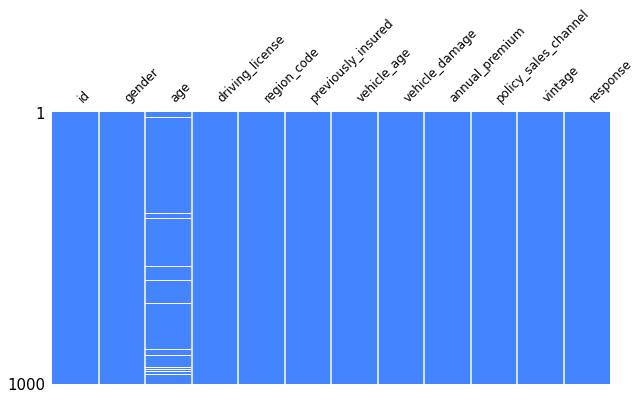

In [70]:
# Verteilung der Missing Values innerhalb der Variablen 
msno.matrix(df.sample(1000), sparkline=False, figsize=(10,5), fontsize=12, color=(0.27, 0.52, 1.0))

<AxesSubplot:>

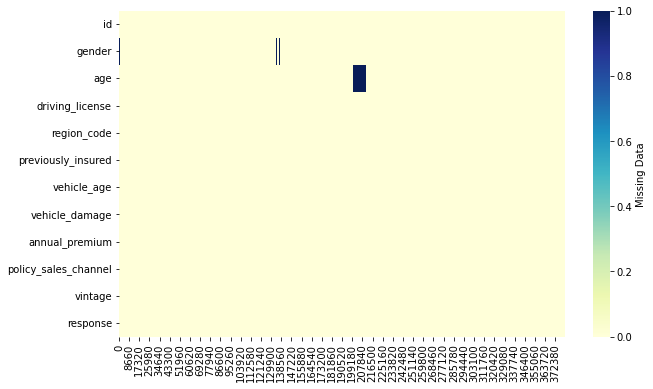

In [71]:

plt.figure(figsize=(10,6))
sns.heatmap(df.isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})


<AxesSubplot:>

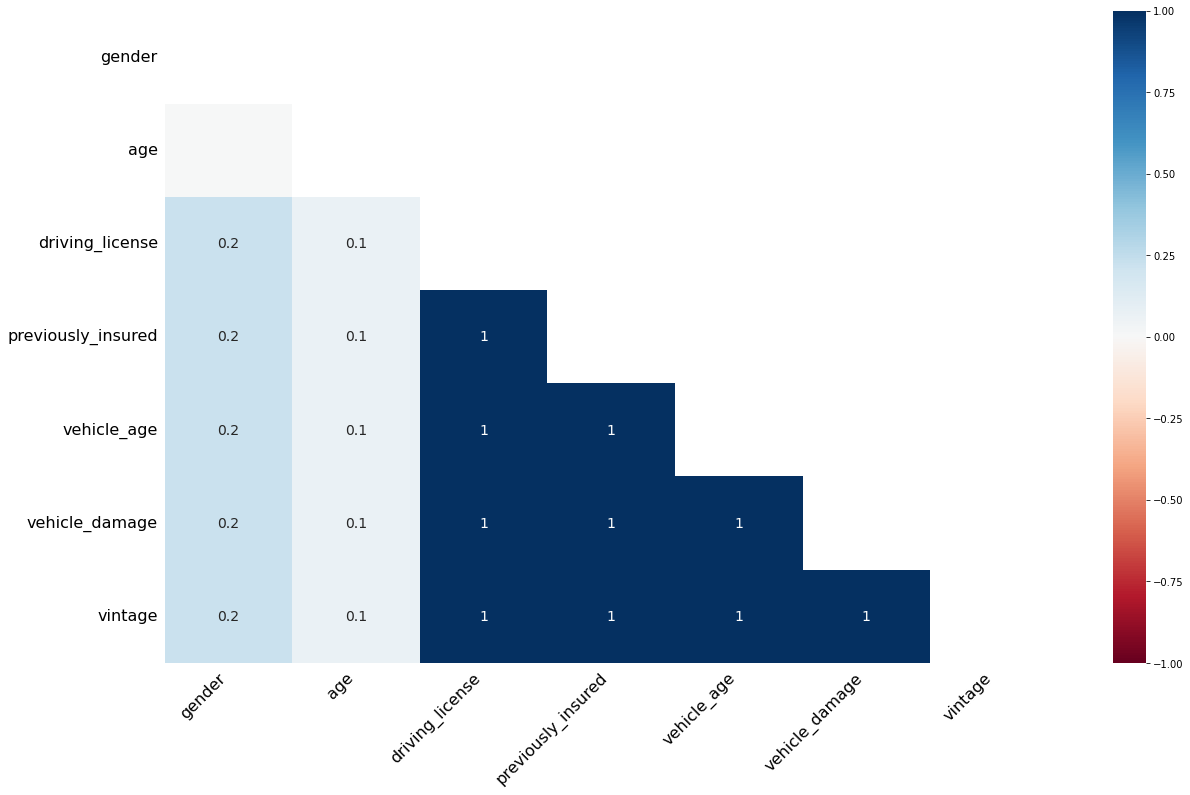

In [72]:
# Visualize the correlation between the number of
# missing values in different columns as a heatmap
msno.heatmap(df)



Um dieses Diagramm zu interpretieren, lesen Sie es aus einer Top-Down-Perspektive. Clusterblätter, die in einem Abstand von Null miteinander verbunden sind, sagen das Vorhandensein des jeweils anderen vollständig voraus - eine Variable könnte immer leer sein, wenn eine andere gefüllt ist, oder sie könnten immer beide gefüllt oder beide leer sein, und so weiter. In diesem speziellen Beispiel klebt das Dendrogramm die Variablen zusammen, die erforderlich und daher in jedem Datensatz vorhanden sind.

Clusterblätter, die sich in der Nähe von Null aufspalten, aber nicht bei Null, sagen sich gegenseitig sehr gut, aber immer noch unvollkommen voraus. Wenn Ihre eigene Interpretation des Datensatzes darin besteht, dass diese Spalten tatsächlich in Null übereinstimmen oder übereinstimmen sollten (z. B. als BETEILIGUNGSFAKTOR FAHRZEUG 2 und FAHRZEUG-TYPCODE 2), dann sagt Ihnen die Höhe des Clusterblatts in absoluten Zahlen, wie oft die Datensätze "nicht übereinstimmen" oder falsch abgelegt sind - d. h. wie viele Werte Sie ausfüllen oder streichen müssten, wenn Sie dazu geneigt sind.

Beschreibung: 
Das Dendrogramm verwendet einen hierarchischen Clustering-Algorithmus, um die Variablen anhand ihrer Nullkorrelation gegeneinander abzugrenzen. 


Erklärung: 
Clutster, die sich in bei Null aufspalten, sagen sich untereinander vollkommen voraus (Korrelation von 1). Auf Grundlage 

Auf jeder Stufe des Baums werden die Variablen auf der Grundlage der Kombination aufgeteilt, die den Abstand der verbleibenden Cluster minimiert.  

Je monotoner die Variablen sind, desto näher liegt ihr Gesamtabstand bei Null und desto näher liegt ihr durchschnittlicher Abstand (die y-Achse) bei Null.   

<AxesSubplot:>

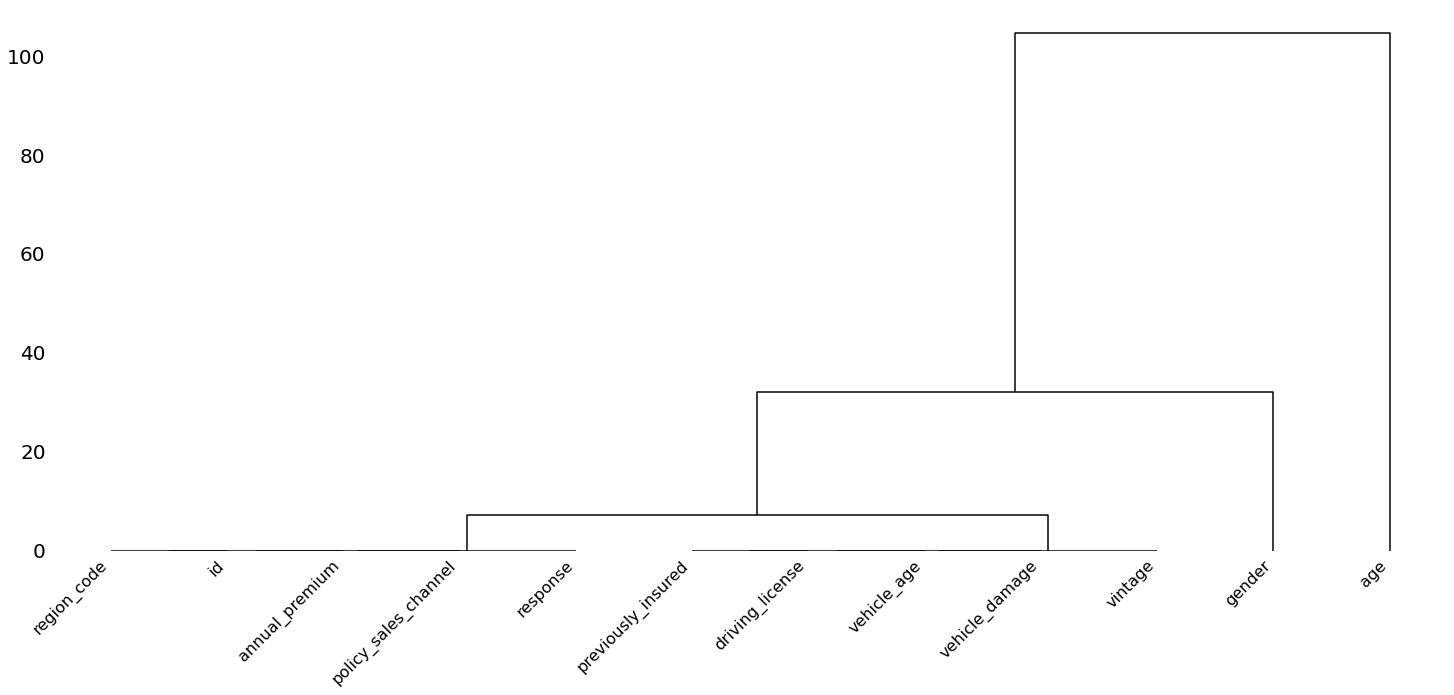

In [73]:
msno.dendrogram(df, orientation='top')

In [74]:
# Verteilung der Missing Values innerhalb der Variablen 
#msno.matrix(df, freq='Tim', sparkline=False)
#df.iloc[:, 0]
#msno.matrix(df.set_index(pd.period_range('1/1/2011', '2/1/2015', freq='M')) , freq='BQ')

In [75]:
# Drop all rows with NaNs in A OR B

#x = df.dropna(subset=['previously_insured', 'driving_license', 'vehicle_age', 'vehicle_damage', 'vintage'])


df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 380999 entries, 0 to 380998
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   id                    380999 non-null  int64   
 1   gender                379948 non-null  category
 2   age                   370107 non-null  Int64   
 3   driving_license       380948 non-null  category
 4   region_code           380999 non-null  category
 5   previously_insured    380948 non-null  category
 6   vehicle_age           380948 non-null  category
 7   vehicle_damage        380948 non-null  category
 8   annual_premium        380999 non-null  Int64   
 9   policy_sales_channel  380999 non-null  Int64   
 10  vintage               380948 non-null  Int64   
 11  response              380999 non-null  category
dtypes: Int64(4), category(7), int64(1)
memory usage: 29.5 MB


In [76]:
df_na_bool = pd.DataFrame(pd.isna(df))

df.drop(df_na_bool[(df_na_bool['previously_insured'] == True) & 
           (df_na_bool['driving_license'] == True) &
           (df_na_bool['vehicle_age'] == True) &
           (df_na_bool['vehicle_damage'] == True) &
           (df_na_bool['vintage'] == True)].index, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 380948 entries, 0 to 380998
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   id                    380948 non-null  int64   
 1   gender                379948 non-null  category
 2   age                   370107 non-null  Int64   
 3   driving_license       380948 non-null  category
 4   region_code           380948 non-null  category
 5   previously_insured    380948 non-null  category
 6   vehicle_age           380948 non-null  category
 7   vehicle_damage        380948 non-null  category
 8   annual_premium        380948 non-null  Int64   
 9   policy_sales_channel  380948 non-null  Int64   
 10  vintage               380948 non-null  Int64   
 11  response              380948 non-null  category
dtypes: Int64(4), category(7), int64(1)
memory usage: 21.4 MB


In [77]:
pd.isna(df).sum()

id                          0
gender                   1000
age                     10841
driving_license             0
region_code                 0
previously_insured          0
vehicle_age                 0
vehicle_damage              0
annual_premium              0
policy_sales_channel        0
vintage                     0
response                    0
dtype: int64

Listenweiser Fallausschluss - Wir haben mittels dem listenweisen Fallausschluss 51 Zeilen aus dem Datensatz entfernt. Dabei haben wir ebenfalls die Anzahl der missing values bei den Variablen von age und gender um 51 Werte reduziert.

## Behandlung von Anomalien

### Age

- Untergrenze: 18
- Obergrenze: 100

In [78]:
index_max_age = df[df["age"] >= 100].index
df.drop(index_max_age, inplace=True)

index_min_age = df[df["age"] < 18].index
df.drop(index_min_age, inplace=True)

df["age"].describe()

count    370007.000000
mean         38.820579
std          15.509008
min          20.000000
25%          25.000000
50%          36.000000
75%          49.000000
max          85.000000
Name: age, dtype: float64

### Annual Premium

- Untergrenze: 0
- Obergrenze: 150.000

In [79]:
index_min_premium = df[df["annual_premium"] <= 0].index
df.drop(index_min_premium, inplace=True)

index_max_premium = df[df["annual_premium"] >= 150000].index
df.drop(index_max_premium, inplace=True)

df["annual_premium"].describe()

df['vehicle_age'].unique()

['> 2 Years', '1-2 Year', '< 1 Year']
Categories (3, object): ['1-2 Year', '< 1 Year', '> 2 Years']

## Train Test Splitting

In [127]:
X = df.drop(['response', 'id'], axis=1)
y = df[['response']]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size = 0.2, random_state=42)

X_train_df = pd.DataFrame(X_train)
y_train_df = pd.DataFrame(y_train)
X_test_df = pd.DataFrame(X_test)
y_test_df = pd.DataFrame(y_test)

len(X_train_df), len(y_train_df), len(X_test_df), len(y_test_df)

(304232, 304232, 76058, 76058)

#### Categorial Mapping

In [128]:
def map_categorials_x(df):

    # driving_license_map = {
    #     'No': 0,
    #     'Yes': 1
    # }

    # previously_insured_map = {
    #     'No': 0,
    #     'Yes': 1
    # }

    # vehicle_age_map = {
    #     '< 1 Year': 0,
    #     '1-2 Year': 1,
    #     '> 2 Years': 2
    # }

    # vehicle_damage_map = {
    #     'No': 0,
    #     'Yes': 1
    # }

    # df.loc[:,'driving_license'] = df['driving_license'].map(driving_license_map)
    # df.loc[:,'previously_insured'] = df['previously_insured'].map(previously_insured_map)
    # df.loc[:,'vehicle_age'] = df['vehicle_age'].map(vehicle_age_map).astype('Int64')
    # df.loc[:,'vehicle_damage'] = df['vehicle_damage'].map(vehicle_damage_map)

    LE = LabelEncoder()
    df['driving_license'] = LE.fit_transform(df.loc[:, 'driving_license'])
    df['previously_insured'] = LE.fit_transform(df.loc[:, 'previously_insured'])
    df['vehicle_age'] = LE.fit_transform(df.loc[:, 'vehicle_age'])
    df['vehicle_damage'] = LE.fit_transform(df.loc[:, 'vehicle_damage'])
    df['region_code'] = LE.fit_transform(df.loc[:,'region_code'])
    df['gender'] = LE.fit_transform(df.loc[:, 'gender'])

    return df

X_train_label_encoded = map_categorials_x(X_train_df.copy())
X_test_label_encoded = map_categorials_x(X_test_df.copy())

def map_categorials_y(df):
    LE = LabelEncoder()

    df['response'] = LE.fit_transform(df.loc[:,'response'])

    return df

y_train_label_encoded = map_categorials_y(y_train_df)
y_test_label_encoded = map_categorials_y(y_test_df)

ONE HOT encoding:

ONE-HOT-ENCODiNG transformiert kategoriale Variablen zu binären Variablen mittels des 'one-hot' Verfahrens.
Dieser Schritt der Kodierung kategorialer Variablen ist nötig, um diese später in linearen Modellen und Vektor Maschinen zu verwenden.

In [129]:
X_train_df_one_hot_encoded_data = pd.get_dummies(X_train_df, columns = ['driving_license', 'gender', 'vehicle_age', 'vehicle_damage', 'previously_insured'])#.dropna()
X_test_df_one_hot_encoded_data = pd.get_dummies(X_test_df, columns = ['driving_license', 'gender', 'vehicle_age', 'vehicle_damage', 'previously_insured'])#.dropna()
X_train_df_one_hot_encoded_data.head()

,age,region_code,annual_premium,policy_sales_channel,vintage,driving_license_No,driving_license_Yes,gender_Female,gender_Male,vehicle_age_1-2 Year,vehicle_age_< 1 Year,vehicle_age_> 2 Years,vehicle_damage_No,vehicle_damage_Yes,previously_insured_No,previously_insured_Yes
115325,22,2.0,27963,152,245,0,1,1,0,0,1,0,1,0,0,1
98707,31,28.0,49872,124,252,1,0,0,1,0,1,0,0,1,1,0
113299,40,4.0,29883,124,211,1,0,0,1,1,0,0,0,1,1,0
235834,51,2.0,31686,124,257,0,1,0,1,1,0,0,1,0,0,1
42893,22,29.0,43698,152,146,1,0,0,1,0,1,0,0,1,1,0


## Imputationverfahren für die Variable Age

### Imputation auf der Train Batch

#### Mean Imputation 

In [130]:
# Create dataset
imputed_train = pd.DataFrame()
imputed_test = pd.DataFrame()
X_test_mean = X_test['age']
X_train_mean = X_train['age']

# Fill missing values of Age with the average of Age (mean)
imputed_train['age'] = X_train_mean.fillna(round(X_train_mean.mean(),0)).astype("Int64")
imputed_test['age'] = X_test_mean.fillna(round(X_test_mean.mean(),0)).astype("Int64")

train_imputed_mean_age = np.array(imputed_train['age'], dtype=int)
test_imputed_mean_age = np.array(imputed_test['age'], dtype=int)
actual_df_age = np.array(df['age'].dropna(), dtype=int)

#### Median Imputation 

In [131]:
# Create dataset
imputed_train_median = pd.DataFrame()
imputed_test_median = pd.DataFrame()
X_test_median = X_test['age']
X_train_median = X_train['age']

# Fill missing values of Age with the average of Age (median)
imputed_train_median['age'] = X_train_median.fillna(round(X_train_median.median(),0)).astype("Int64")
imputed_test_median['age'] = X_test_median.fillna(round(X_test_median.mean(),0)).astype("Int64")

train_imputed_median_age = np.array(imputed_train_median['age'], dtype=int)
test_imputed_median_age = np.array(imputed_test_median['age'], dtype=int)
actual_df_age = np.array(df['age'].dropna(), dtype=int)

#### K-Nearest Neighbour

In [132]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline

results = list()
strategies = [str(i) for i in [1,3,5,7,9,15,18,21]]
for s in strategies:
	# create the modeling pipeline
	pipeline = Pipeline(steps=[('i', KNNImputer(n_neighbors=int(s))), ('m', RandomForestClassifier())])
	# evaluate the model
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(pipeline, X_train_label_encoded, y_train_label_encoded, scoring='accuracy', cv=cv, n_jobs=-1)
	# store results
	results.append(scores)
	print('>%s %.3f (%.3f)' % (s, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=strategies, showmeans=True)
plt.show()

In [124]:
knn = KNNImputer(n_neighbors=7, weights='uniform')

# Modellierung auf Trainingsdaten
X_train_df_knn_X = X_train_df_one_hot_encoded_data.copy()

X_knn_train = knn.fit_transform(X_train_df_knn_X)
X_train_df_knn = pd.DataFrame(X_knn_train, columns=X_train_df_knn_X.columns)

# Modellierung auf Testdaten
X_test_df_knn_X = X_test_label_encoded.copy()

X_knn_test = np.round(knn.fit_transform(X_test_df_knn_X))
X_test_df_knn = pd.DataFrame(X_knn_test, columns=X_test_df_knn_X.columns)

<AxesSubplot:>

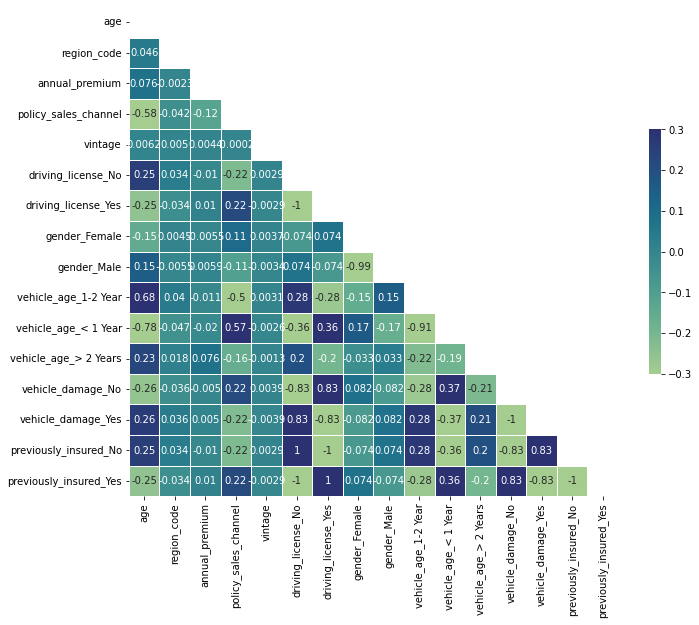

In [125]:
# Create the correlation matrix
corr = X_train_df_knn.corr()

# Generate a mask for the upper triangle; True = do NOT show
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.color_palette("crest", as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    corr,          # The data to plot
    mask=mask,     # Mask some cells
    cmap=cmap,     # What colors to plot the heatmap as
    annot=True,    # Should the values be plotted in the cells?
    vmax=.3,       # The maximum value of the legend. All higher vals will be same color
    vmin=-.3,      # The minimum value of the legend. All lower vals will be same color
    center=0,      # The center value of the legend. With divergent cmap, where white is
    square=True,   # Force cells to be square
    linewidths=.5, # Width of lines that divide cells
    cbar_kws={"shrink": .5}  # Extra kwargs for the legend; in this case, shrink by 50%
)

In [87]:
X_train_label_encoded['age'].unique()

<IntegerArray>
[  24,   20,   23,   22,   61,   70,   36,   25,   56,   26,   33,   27,   75,
   44,   50, <NA>,   47,   68,   73,   53,   46,   43,   37,   21,   41,   38,
   63,   40,   29,   28,   42,   79,   30,   35,   58,   71,   34,   45,   60,
   72,   76,   48,   64,   80,   49,   57,   32,   69,   52,   31,   54,   59,
   39,   67,   55,   62,   65,   51,   74,   66,   78,   77,   82,   84]
Length: 64, dtype: Int64

#### Miss Forest

In [123]:
from sklearn.experimental import enable_iterative_imputer

# Modellierung auf den Trainingsdaten
X_train_df_mice_X = X_train_label_encoded.copy()

mice_imputer = IterativeImputer()
X_mice = mice_imputer.fit_transform(X_train_df_mice_X)
X_train_df_mice = pd.DataFrame(X_mice, columns=X_train_df_mice_X.columns)
X_train_df_mice['gender'] = X_train_df_mice['gender'].round()

# Modellierung auf den Testdaten
X_test_df_mice_X = X_test_label_encoded.copy()

X_mice = mice_imputer.fit_transform(X_test_df_mice_X)
X_test_df_mice = pd.DataFrame(X_mice, columns=X_test_df_mice_X.columns)
X_test_df_mice['gender'] = X_test_df_mice['gender'].round()

#### Lineares Regressionsmodell

In [91]:
# Modellierung auf den Trainingsdaten
df_linear_model_w_na = X_train_df_one_hot_encoded_data.copy().dropna(subset=['age', 'region_code'])
df_linear_model = X_train_df_one_hot_encoded_data.copy()[['age', 'region_code']]

X_reg = df_linear_model_w_na[['region_code']]
y_reg = df_linear_model_w_na[['age']]

age_missing = df_linear_model['age'].isnull()
df_age_missing = pd.DataFrame(df_linear_model['region_code'][age_missing])

X_train_regression, X_test_regression, y_train_regression, y_test_regression = train_test_split(X_reg, y_reg, train_size=0.8, test_size = 0.2, random_state=42)

lm = LinearRegression()
lm.fit(X_train_regression, y_train_regression)

#yp = pd.DataFrame(lm.predict(df_age_missing).round(), columns=['pred'])

#df_linear_model = df_linear_model['age'].apply(lambda x: x.fillna())
#df_linear_model.isna().sum(), yp['pred']

LinearRegression()

#### Visualisierung der Imputationsverfahren

In [126]:
hist_data_train = [X_train_df_mice['age'], X_train_df_knn['age'], train_imputed_mean_age, train_imputed_median_age, actual_df_age]

group_labels = ['train_imputed_mice_age','train_imputed_knn_age','train_imputed_mean_age', 'train_imputed_median_age', 'actual_df_age']
colors = ['#333F44', '#37AA9C', '#f3722c', '#6a994e', '#0077b6']

# Create distplot with curve_type set to 'normal'
fig = ff.create_distplot(hist_data_train, group_labels, show_hist=False, colors=colors, rug_text=None, show_rug=False)

fig.update_layout(legend=dict(x=0.88,y=1,traceorder="reversed",title_font_family="Times New Roman",font=dict(family="Courier",size=12,color="black"),bgcolor="LightSteelBlue",bordercolor="#fff",borderwidth=2))

# Add title
fig.update_layout(title_text='Verteilung der Variable nach Imputationsverfahren in der Train Batch')
fig.show()

## Imputationverfahren für die Variable Gender

In [93]:
fig = make_subplots(rows=1)

fig.add_trace(go.Bar(name="Ursprüngliche Verteilung",x = X_train_df['gender'].replace({0: 'Female', 1: 'Male'}), y = X_train_df['gender'].value_counts(normalize=True),
                                    text = X_train_df['gender'].value_counts(normalize=True).apply(lambda x: '{0:1.3f}%'.format(x))
                        ))

fig.add_trace(go.Bar(name="Verteilung nach MICE Imputation", x = X_train_df_mice['gender'].replace({0: 'Female', 1: 'Male'}), y = X_train_df_mice['gender'].value_counts(normalize=True),
                                    text = X_train_df_mice['gender'].value_counts(normalize=True).apply(lambda x: '{0:1.3f}%'.format(x))
                        ))

fig.add_trace(go.Bar(name="Verteilung nach MICE Imputation", x = X_train_df_knn['gender'].replace({0: 'Female', 1: 'Male'}), y = X_train_df_knn['gender'].value_counts(normalize=True),
                                    text = X_train_df_knn['gender'].value_counts(normalize=True).apply(lambda x: '{0:1.3f}%'.format(x))
                        ))


fig.update_layout(title_text="Relative Verteilung der Variable Gender")

fig.show()

### Imputation auf der Test Batch 

In [94]:
hist_data_test = [X_test_df_mice['age'], X_test_df_knn['age'], test_imputed_mean_age, test_imputed_median_age, actual_df_age]

group_labels = ['test_imputed_mice_age','test_imputed_knn_age','test_imputed_mean_age', 'test_imputed_median_age', 'actual_df_age']
colors = ['#333F44', '#37AA9C', '#f3722c', '#6a994e', '#0077b6']

# Create distplot with curve_type set to 'normal'
fig = ff.create_distplot(hist_data_test, group_labels, show_hist=False, colors=colors, rug_text=None, show_rug=False)
fig.update_layout(legend=dict(x=0.88,y=1,traceorder="reversed",title_font_family="Times New Roman",font=dict(family="Courier",size=12,color="black"),bgcolor="LightSteelBlue",bordercolor="#fff",borderwidth=2))

# Add title
fig.update_layout(title_text='Verteilung der Variable nach Imputationsverfahren in der Test Batch')
fig.show()

<AxesSubplot:>

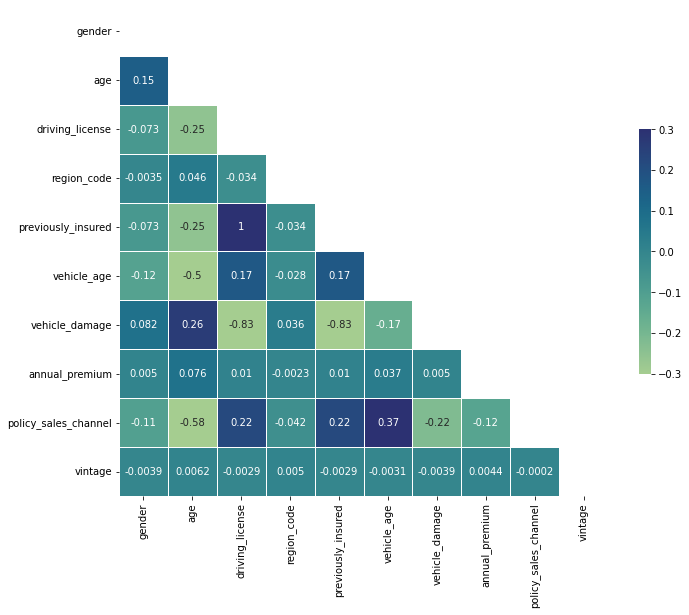

In [95]:
corr = X_train_df_knn.corr()

mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.color_palette("crest", as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    corr,          # The data to plot
    mask=mask,     # Mask some cells
    cmap=cmap,     # What colors to plot the heatmap as
    annot=True,    # Should the values be plotted in the cells?
    vmax=.3,       # The maximum value of the legend. All higher vals will be same color
    vmin=-.3,      # The minimum value of the legend. All lower vals will be same color
    center=0,      # The center value of the legend. With divergent cmap, where white is
    square=True,   # Force cells to be square
    linewidths=.5, # Width of lines that divide cells
    cbar_kws={"shrink": .5}  # Extra kwargs for the legend; in this case, shrink by 50%
)

#### Oversampling

In [96]:
X_train_df_os = pd.concat([X_train,y_train],axis=1)

response_no = X_train_df_os[X_train_df_os.response == 'no']
response_yes = X_train_df_os[X_train_df_os.response == 'yes']

# upsample minority
response_upsampled = resample(response_yes,
                          replace=True, # sample with replacement
                          n_samples=len(response_no), # match number in majority class
                          random_state=42) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([response_no, response_upsampled])

# check new class counts
upsampled.response.value_counts()

Series([], Name: response, dtype: int64)

In [97]:
df_upsampled_response = upsampled.groupby(['response']).size().reset_index()
fig = px.bar(df_upsampled_response, x='response', y=upsampled['response'].value_counts(normalize=False), color='response',
                                    text=upsampled['response'].value_counts(normalize=False),
                                    color_discrete_map={
                                        'yes': 'rgb(18,116,117)',
                                        'no': 'rgb(20,29,67)'
                                    })

fig.update_layout(title='Relative Verteilung der Ausprägungen von Response nach dem Upsampling',
                 xaxis_title='Response',
                 yaxis_title='Count')
fig.show()

In [98]:
X_train_df_us = pd.concat([X_train_df_knn.reset_index(drop=True), y_train_df.reset_index(drop=True)], axis=1)
print(X_train_df_us.head())

   gender   age  driving_license  region_code  previously_insured  \
0     0.0  24.0              1.0         32.0                 1.0   
1     0.0  20.0              1.0         46.0                 1.0   
2     0.0  23.0              1.0          1.0                 1.0   
3     1.0  22.0              1.0         30.0                 1.0   
4     1.0  61.0              0.0         46.0                 0.0   

   vehicle_age  vehicle_damage  annual_premium  policy_sales_channel  vintage  \
0          1.0             0.0          2630.0                 160.0     87.0   
1          1.0             0.0         72845.0                 160.0    242.0   
2          1.0             0.0          2630.0                 152.0     28.0   
3          1.0             0.0         30237.0                 152.0    258.0   
4          0.0             1.0         40988.0                  26.0    192.0   

   response  
0         0  
1         0  
2         0  
3         0  
4         0  


#### Undersampling mit einem einfachen Modell evaluieren 

In [99]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# define undersampling strategy
undersample = RandomUnderSampler(sampling_strategy='auto')

# summarize class distribution
print("Before undersampling: ", Counter(y_train['response']))

# fit and apply the transform
X_train_under, y_train_under = undersample.fit_resample(X_train_df_knn, y_train)
X_test_under, y_test_under = undersample.fit_resample(X_test_df_knn, y_test)

print(len(X_train_under), len(y_train_under))
print(len(X_test_under), len(y_test_under))
# summarize class distribution
print("After undersampling: ", Counter(y_train_under['response']))


from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score

model=SVC()
clf_under = model.fit(X_train_under, y_train_under)
pred_under = clf_under.predict(X_test_df_knn)

print("ROC AUC score for undersampled data: ", roc_auc_score(y_test_label_encoded, pred_under))

Before undersampling:  Counter({0: 16679, 1: 2335})
4670 4670
910 910
After undersampling:  Counter({0: 2335, 1: 2335})


c:\Users\aster\Documents_\Hochschule\Data Analysis Hausarbeit\Hausarbeit\venv\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



ROC AUC score for undersampled data:  0.5473095303740465


In [100]:
# df_downsampled_response = downsampled.groupby(['response']).size().reset_index()
# fig = px.bar(df_downsampled_response, x='response', y=downsampled['response'].value_counts(normalize=False), color='response',
#                                     text=downsampled['response'].value_counts(normalize=False),
#                                     color_discrete_map={
#                                         'yes': 'rgb(18,116,117)',
#                                         'no': 'rgb(20,29,67)'
#                                     })

# fig.update_layout(title='Relative Verteilung der Ausprägungen von Response nach dem Undersampling',
#                  xaxis_title='Response',
#                  yaxis_title='Count')
# fig.show()

#### Oversampling \w SMOTE

SMOTE (Synthetic Minority Oversampling Technique) consists of synthesizing elements for the minority class, based on those that already exist. It works randomly picking a point from the minority class and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbors.

In [101]:
# import SMOTE oversampling and other necessary libraries 

pipeline = imbpipeline(steps = [['smote', SMOTE(sampling_strategy='auto' ,random_state=11, n_jobs=-1)],
                                ['scaler', MinMaxScaler()],
                                ['classifier', LogisticRegression(random_state=11,
                                                                  max_iter=1000)]])

stratified_kfold = StratifiedKFold(n_splits=5,
                                       shuffle=True,
                                       random_state=11)

param_grid = {'classifier__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           cv=stratified_kfold,
                           n_jobs=-1)


grid_search.fit(X_train_df_knn, y_train_df['response'])
print(grid_search.best_params_)
cv_score = grid_search.best_score_
test_score = grid_search.score(X_test_df_knn, y_test_df['response'])
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

{'classifier__C': 0.1}
Cross-validation score: 0.8144806064301049
Test score: 0.8195445534155212


In [102]:
smote = SMOTE()

X_train_SMOTE, y_train_SMOTE = smote.fit_resample(X_train_df_knn, y_train_df['response'])
X_test_SMOTE, y_test_SMOTE = smote.fit_resample(X_test_df_knn, y_test_df['response'])

<AxesSubplot:>

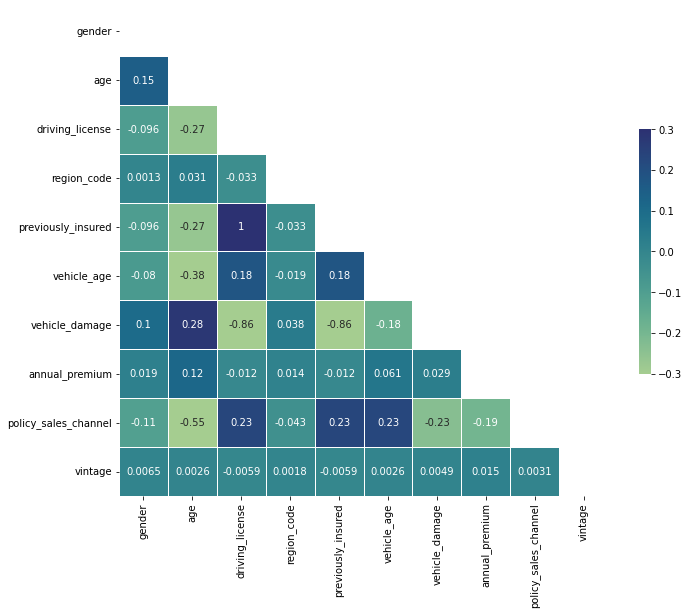

In [103]:
# Create the correlation matrix
corr = X_train_SMOTE.corr()

# Generate a mask for the upper triangle; True = do NOT show
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.color_palette("crest", as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    corr,          # The data to plot
    mask=mask,     # Mask some cells
    cmap=cmap,     # What colors to plot the heatmap as
    annot=True,    # Should the values be plotted in the cells?
    vmax=.3,       # The maximum value of the legend. All higher vals will be same color
    vmin=-.3,      # The minimum value of the legend. All lower vals will be same color
    center=0,      # The center value of the legend. With divergent cmap, where white is
    square=True,   # Force cells to be square
    linewidths=.5, # Width of lines that divide cells
    cbar_kws={"shrink": .5}  # Extra kwargs for the legend; in this case, shrink by 50%
)

##### Feature Engineering 

In [104]:
import featuretools as ft
from feature_engine.creation import CombineWithReferenceFeature
from feature_engine.creation import MathematicalCombination
from feature_engine.selection import SelectByTargetMeanPerformance

from sklearn.preprocessing import MinMaxScaler, QuantileTransformer, StandardScaler

In [105]:
combinator = MathematicalCombination(
    variables_to_combine=['annual_premium', 'vintage'],
    math_operations=['mean', 'prod', 'sum', 'std'],
    new_variables_names=['mean_annual_vintage', 'prod_annual_vintage', 'sum_annual_vintage', 'std_annual_vintage']
)

X_train_df_fe = combinator.fit_transform(X_train_df_knn, y_train)

print(combinator.combination_dict_)

print(X_train_df_fe.loc[:, ['annual_premium', 'vintage', 'mean_annual_vintage', 'prod_annual_vintage', 'sum_annual_vintage', 'std_annual_vintage']].head())

{'mean_annual_vintage': 'mean', 'prod_annual_vintage': 'prod', 'sum_annual_vintage': 'sum', 'std_annual_vintage': 'std'}
   annual_premium  vintage  mean_annual_vintage  prod_annual_vintage  \
0          2630.0     87.0               1358.5             228810.0   
1         72845.0    242.0              36543.5           17628490.0   
2          2630.0     28.0               1329.0              73640.0   
3         30237.0    258.0              15247.5            7801146.0   
4         40988.0    192.0              20590.0            7869696.0   

   sum_annual_vintage  std_annual_vintage  
0              2717.0         1798.172545  
1             73087.0        51338.073634  
2              2658.0         1839.891845  
3             30495.0        21198.354193  
4             41180.0        28847.128245  


In [106]:
age_bin = X_train_df_fe[['age']]

X_train_df_fe['age_bin'] = pd.cut(X_train_df_fe['age'], bins=[18, 40, 60, 80, 100], labels=['18-40', '40-60', '60-80', '80-100'])
X_train_df_fe.isna().sum()

gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
mean_annual_vintage     0
prod_annual_vintage     0
sum_annual_vintage      0
std_annual_vintage      0
age_bin                 0
dtype: int64

Standard scaling removes mean and scale data to unit variance.

In [107]:
standart_scaler = StandardScaler()

scaled_data = X_train_df_fe[['annual_premium']]

X_train_df_fe['annual_premium_scaled'] = standart_scaler.fit_transform(X_train_df_fe[['annual_premium']])

print('Mean:', X_train_df_fe['annual_premium_scaled'].mean())
print('Standard Deviation:', X_train_df_fe['annual_premium_scaled'].std())

Mean: -8.651027838879941e-17
Standard Deviation: 1.0000262974504668


The most popular scaling technique is normalization (also called min-max normalization and min-max scaling). It scales all data in the 0 to 1 range.

In [108]:
minmax_scaler = MinMaxScaler()

X_train_df_fe['annual_premium_min_max_scaled'] = minmax_scaler.fit_transform(X_train_df_fe[['annual_premium']])

print('Mean:', X_train_df_fe['annual_premium_min_max_scaled'].mean())
print('Standard Deviation:', X_train_df_fe['annual_premium_min_max_scaled'].std())

Mean: 0.19883191316592094
Standard Deviation: 0.1154226516064819


As we mentioned, sometimes machine learning algorithms require that the distribution of our data is uniform or normal.

In [109]:
qtrans = QuantileTransformer()

X_train_df_fe['annual_premium_q_trans_uniform'] = qtrans.fit_transform(X_train_df_fe[['annual_premium']])

print('Mean:', X_train_df_fe['annual_premium_q_trans_uniform'].mean())
print('Standard Deviation:', X_train_df_fe['annual_premium_q_trans_uniform'].std())

Mean: 0.486315408659375
Standard Deviation: 0.30876112738541206


In [110]:
qtrans_normal = QuantileTransformer(output_distribution='normal', random_state=42)

X_train_df_fe['annual_premium_q_trans_normal'] = qtrans_normal.fit_transform(X_train_df_fe[['annual_premium']])

print('Mean:', X_train_df_fe['annual_premium_q_trans_normal'].mean())
print('Standard Deviation:', X_train_df_fe['annual_premium_q_trans_normal'].std())

Mean: -0.6115754764103939
Standard Deviation: 2.1660911517706323


In [111]:
corr = X_train_df_fe.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

C:\Users\aster\AppData\Local\Temp/ipykernel_29940/1896346534.py:2: FutureWarning:

this method is deprecated in favour of `Styler.format(precision=..)`



,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,mean_annual_vintage,prod_annual_vintage,sum_annual_vintage,std_annual_vintage,annual_premium_scaled,annual_premium_min_max_scaled,annual_premium_q_trans_uniform,annual_premium_q_trans_normal
gender,1.00,0.15,-0.07,-0.00,-0.07,-0.12,0.08,0.01,-0.11,-0.00,0.01,0.00,0.01,0.01,0.01,0.01,0.02,-0.01
age,0.15,1.00,-0.25,0.05,-0.25,-0.50,0.26,0.08,-0.58,0.01,0.08,0.05,0.08,0.08,0.08,0.08,0.10,0.01
driving_license,-0.07,-0.25,1.00,-0.03,1.00,0.17,-0.83,0.01,0.22,-0.00,0.01,0.00,0.01,0.01,0.01,0.01,-0.02,0.05
region_code,-0.00,0.05,-0.03,1.00,-0.03,-0.03,0.04,-0.00,-0.04,0.01,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.01
previously_insured,-0.07,-0.25,1.00,-0.03,1.00,0.17,-0.83,0.01,0.22,-0.00,0.01,0.00,0.01,0.01,0.01,0.01,-0.02,0.05
vehicle_age,-0.12,-0.50,0.17,-0.03,0.17,1.00,-0.17,0.04,0.37,-0.00,0.04,0.03,0.04,0.04,0.04,0.04,0.02,0.07
vehicle_damage,0.08,0.26,-0.83,0.04,-0.83,-0.17,1.00,0.00,-0.22,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03,-0.03
annual_premium,0.01,0.08,0.01,-0.00,0.01,0.04,0.00,1.00,-0.12,0.00,1.00,0.66,1.00,1.00,1.00,1.00,0.95,0.93
policy_sales_channel,-0.11,-0.58,0.22,-0.04,0.22,0.37,-0.22,-0.12,1.00,-0.00,-0.12,-0.08,-0.12,-0.12,-0.12,-0.12,-0.14,-0.07
vintage,-0.00,0.01,-0.00,0.01,-0.00,-0.00,-0.00,0.00,-0.00,1.00,0.01,0.67,0.01,-0.00,0.00,0.00,0.01,0.00


#### Evalutation

In [112]:
X_train_SMOTE.to_csv('../data/x_train_clean.csv', sep="$", decimal=".")
y_train_SMOTE.to_csv('../data/y_train_clean.csv', sep="$", decimal=".")

X_test_SMOTE.to_csv('../data/x_test_clean.csv', sep="$", decimal=".")
y_test_SMOTE.to_csv('../data/y_test_clean.csv', sep="$", decimal=".")